# Matrix Factorization

## name: Fujiwara Daigo(藤原大悟)
## student number: 6930-31-6255
## date: 7/27/2019

## 1. About  the Data

The data is from a part of “EachMovie” dataset
(http://www.cs.cmu.edu/~lebanon/IR-lab/data.html)

Analyze the rating data of 1623 movies by 1000 users.

Make a recommendation system to offer best movies for each user by matrix factorization.

The data is like bellow:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#import data
df=pd.read_table("/Users/daigofujiwara/Documents/授業資料/論理生命学/MatrixFactorization/movie.txt",header=None,sep=" ")
print("(row,col)=",df.shape)
df.head()

(row,col)= (1000, 1623)


,0,1,2,3,4,5,6,7,8,9,...,1613,1614,1615,1616,1617,1618,1619,1620,1621,1622
0,0,0,0,0,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,6,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,4,0,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0



## 2. Formulation of Method1

I will explain a formulation of the recommendation problem and a solution using matrix factorization, using the following notations: $r_{ij}$ is the rating score of item i given by user j. $\Omega$ is the set of the indices of observed ratings, i.e. $r_{ij}$ is observed if $(i,j)\in\Omega$


First, in recomendation, usually the size of dimension and sample data is large, and rating score matrix is sparse, so we need feature reduction.Feature reduction model is expressed as bellow:
$$
\boldsymbol{R}=\boldsymbol{U}^{T}V
$$

$$
\{\boldsymbol{R}\}_{i j}=r_{i j}, \boldsymbol{R} \in \mathbb{R}^{m \times n}, \boldsymbol{U} \in \mathbb{R}^{k \times m}, \boldsymbol{V} \in \mathbb{R}^{k \times n}, \min (m, n) \geq k
$$

Then naively it is come up with the idea of interpretting un-observed value to zero, and by SVD, reducing dimension of rating score matrix. However, in this idea, we thought un-observed value of rating score as zero, but in fact, un-obseved value is just ”un-observed” and not neessarily zero, so this model is not better.

Alternartively, there is some way filling un-observed value by regression or minimizing error.
In this method, U,V is determined based on only observed score, minimizing this loss
function:

$$
\min _{U, V}L=\min _{U, V} \left(\sum_{(i, j) \in \Omega}\left(r_{i j}-\boldsymbol{u}_{i}^{\top} \boldsymbol{v}_{j}\right)^{2}+\lambda_{1}\|\boldsymbol{U}\|_{F}^{2}+\lambda_{2}\|\boldsymbol{V}\|_{F}^{2}\right)
$$

where, 
$$
\boldsymbol{U}=\left[\boldsymbol{u}_1,\boldsymbol{u}_2,\dots ,\boldsymbol{u}_m\right]\\
\boldsymbol{V}=\left[\boldsymbol{v}_1,\boldsymbol{v}_2,\dots ,\boldsymbol{v}_n\right]
$$

Minimizing this loss is done by these alternative update.


$$
\boldsymbol{u}_{i} =\left(\sum_{(i, j) \in \Omega} \boldsymbol{v}_{j} \boldsymbol{v}_{j}^{\top}+\lambda_{1} \boldsymbol{I}\right)^{-1} \sum_{(i, j) \in \Omega} r_{i j} \boldsymbol{v}_{j} \tag{1}$$ $$ \boldsymbol{v}_{j} =\left(\sum_{(i, j) \in \Omega} \boldsymbol{u}_{i} \boldsymbol{u}_{i}^{\top}+\lambda_{2} \boldsymbol{I}\right)^{-1} \sum_{(i, j) \in \Omega} r_{i j} \boldsymbol{u}_{i} \tag{2}
$$

Each update formula is derived from Loss's partial differential.
$$
L=\sum_{(i, j) \in \Omega}\left(r_{i j}-\boldsymbol{u}_{i}^{\top} \boldsymbol{v}_{j}\right)^{2}+\lambda_{1}\|\boldsymbol{U}\|_{F}^{2}+\lambda_{2}\|\boldsymbol{V}\|_{F}^{2}\\
$$
$$
\frac{\partial L}{\partial \boldsymbol u_i}=2\sum_{(i, j) \in \Omega}(\boldsymbol u^T_i \boldsymbol v_j-r_{ij})\boldsymbol v_j
+2\lambda_1 \boldsymbol u_i=0\\
\therefore \left(\sum_{(i, j) \in \Omega}\boldsymbol v_j \boldsymbol v_j^T+\lambda_1 \boldsymbol I\right)\boldsymbol u_i
=\sum_{(i, j) \in \Omega}r_{ij}\boldsymbol v_j$$$$
\therefore \boldsymbol{u}_{i} =\left(\sum_{(i, j) \in \Omega} \boldsymbol{v}_{j} \boldsymbol{v}_{j}^{\top}+\lambda_{1} \boldsymbol{I}\right)^{-1} \sum_{(i, j) \in \Omega} r_{i j} \boldsymbol{v}_{j} \tag{1}
$$

And as well, from $\frac{\partial L}{\partial \boldsymbol v_j}$, formula (2) is derived.

In [4]:
Rmasked = df.values.copy()
Rmasked = Rmasked.T
Rmasked[:100,:100]=np.zeros((100,100))

class MatrixFactorization:
    def __init__(self,R):
        self.R=R.copy()
        #parameter
        self.M=R.shape[0]
        self.N=R.shape[1]
        ##initializing matrix
        self.R_exist = np.where(R!=0)
        self.R_exist = np.array([self.R_exist[0],self.R_exist[1]])
        
    def fit(self,K,noprint=1):
        ##initializing matrix            
        U=np.random.rand(self.M,K)
        V=np.random.rand(self.N,K)
        #calculate loss
        loss=np.inf
        ##regularization coefficient
        lambda0=1
        lambda1=lambda0
        lambda2=self.M/self.N*lambda0
        
        self.Loss=[]
        
        k=0
        if not noprint:
            print("loss=")
        while 1:
            for i in range(self.M):
                #extract observed area in i row 
                arr=self.R_exist[1,(self.R_exist==i)[0]]
                temp1=np.zeros((K,K))
                temp2=np.zeros(K)
                for j in arr:
                    temp1=temp1+np.dot(V[j].reshape(V[j].shape[0],1),V[j].reshape(1,V[j].shape[0]))
                    temp2=temp2+self.R[i,j]*V[j]
                inv=np.linalg.inv(temp1+lambda1*np.eye(K))
                U[i]=np.dot(temp2,inv)

            temp3=0

            for j in range(self.N):
                #extract observed area in j colm
                arr=self.R_exist[0,(self.R_exist==j)[1]]
                temp1=np.zeros((K,K))
                temp2=np.zeros(K)
                for i in arr:
                    temp1=temp1+np.dot(U[i].reshape(U[i].shape[0],1),U[i].reshape(1,U[i].shape[0]))
                    temp2=temp2+self.R[i,j]*U[i]
                    #calculate loss
                    temp3+=np.square(self.R[i,j]-np.dot(U[i],V[j]))
                inv=np.linalg.inv(temp1+lambda2*np.eye(K))
                V[j]=np.dot(temp2,inv)

            pre=loss

            loss=temp3+lambda1*np.linalg.norm(U,ord=2)*np.linalg.norm(U,ord=2) \ 
            +lambda2*np.linalg.norm(V,ord=2)*lambda2*np.linalg.norm(V,ord=2)

            self.Loss.append([loss,k])
            
            if pre-loss<0.1 or k>1000:
                break
            if not noprint:
                if not (k%10):
                    print(loss,", iter=",k)
            k+=1
        
        if not noprint:
            print("finished !")
        self.U=U
        self.V=V
        self.Loss=np.array(self.Loss)
        self.Loss=self.Loss.T
        self.Rest=np.dot(U,V.T)
        return self.Rest

## 3. Implementation

## 3.1 Confirmation the decrease of loss

Confirming the decrease of loss, using reduced dimension k=5 model and showing the graph of loss decrease for each iteration step.

In [5]:
mf=MatrixFactorization(Rmasked)
Rest=mf.fit(5,noprint=0)

loss=
187724.70798117723 , iter= 0
73837.51096647854 , iter= 10
72980.55351907827 , iter= 20
72805.70560859605 , iter= 30
72780.94787997485 , iter= 40
finished !


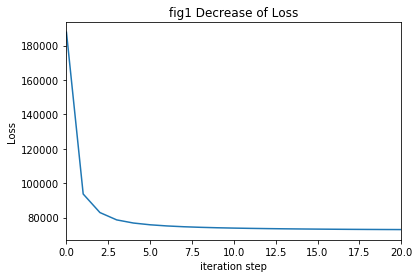

In [6]:
plt.title("fig1 Decrease of Loss")
plt.plot(mf.Loss[1],mf.Loss[0])
plt.xlabel("iteration step")
plt.xlim(0,20)
plt.ylabel("Loss")
plt.show()

## 3.2 Evaluation

Hiding upper left 100x100 rating data, I estimate the rating matrix by ALS.
After that, revealing the real value, I compare estimation value and real value. I use RMSE as the evaluation criteria.

$$
RMSE=\sqrt{\frac{1}{N_\Omega}\sum_{(i, j) \in \Omega}\left(r_{i j}-\boldsymbol{u}_{i}^{\top} \boldsymbol{v}_{j}\right)^{2}}
$$

$N_\Omega$ is the number of elements of $\Omega$. $\Omega$ is now limited to upper left 100x100 area.

And I compare the RMSEs of our model and Ramdom model.

### (model dimension) k=5 method1 model

In thi part, we use our matrix factorization model as k=5 and calculate RMSE.

In [7]:
RealR=df.values.copy()
RealR=RealR.T
RealR=RealR[:100,:100]
R_estimate=mf.Rest[:100,:100]

R_exist100 = np.where(RealR!=0)
R_exist100 = np.array([R_exist100[0],R_exist100[1]])

err=0

for i in range(100):
        arr=R_exist100[1,(R_exist100==i)[0]]
        for j in arr:
            err+=np.square(RealR[i,j]-R_estimate[i,j])
            
MSE=err/R_exist100.shape[1]
RMSE=np.sqrt(MSE)
RMSE

1.1292267112130494

RMSE is about 1.129

### Random model

 In this model,it is used uniform distribution in the section $[1,6]$ for each value of estimation matrix. 

In [8]:
R_uni=1+5*np.random.rand(100,100)
err=0
for i in range(100):
        arr=R_exist100[1,(R_exist100==i)[0]]
        for j in arr:
            err+=np.square(RealR[i,j]-R_uni[i,j])
            
MSE_uni=err/R_exist100.shape[1]
RMSE_uni=np.sqrt(MSE_uni)
RMSE_uni

2.193987378539665

RMSE is about 2.194

### small conlusion
It is concluded that this method is superior to random estimation.

## 3.3 Transition of each K

I made some models where model dimesion $k$ is deifferent, observed the transition for each $k$, and estimte the best model. 

In [9]:
RealR=df.values.copy()
RealR=RealR.T
RealR=RealR[:100,:100]
R_exist100 = np.where(RealR!=0)
R_exist100 = np.array([R_exist100[0],R_exist100[1]])
Ks=list([1,2,3,4,5,6,7,8,9,10])
Rests=[]

In [10]:
for k in Ks:
    Rests.append(mf.fit(k))

In [11]:
MSEs=np.array([])

for k in range(len(Rests)):
    err=0

    for i in range(100):
            arr=R_exist100[1,(R_exist100==i)[0]]
            for j in arr:
                err+=np.square(RealR[i,j]-Rests[k][i,j])

    MSEs=np.append(MSEs,err/R_exist100.shape[1])

RMSEs=np.sqrt(MSEs)

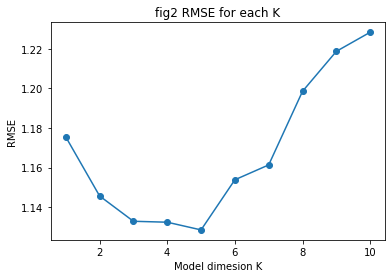

In [12]:
plt.title("fig2 RMSE for each K")
plt.plot(Ks,RMSEs,"o-")
plt.xlabel("Model dimesion K")
plt.ylabel("RMSE")
plt.show()

### small conclusion

The best model is $k=3$ or $k=5$ model. And too large $k$ makes the acuracy of model worse. It is very suprising because naively we think that more degree of freedom can make RMSE smaller. 

Then, I will also show the acuracy (RMSE) for the trainnig data. In other words,
$$
\overline{RMSE}=\sqrt{\frac{1}{N_\overline\Omega}\sum_{(i, j) \in \overline\Omega}\left(r_{i j}-\boldsymbol{u}_{i}^{\top} \boldsymbol{v}_{j}\right)^{2}}
$$

In [13]:
RealR_=df.values.copy()
RealR_=RealR_.T
MSEs_=np.array([])

for k in range(len(Rests)):
    err=0

    for i in range(mf.M):
            arr=mf.R_exist[1,(mf.R_exist==i)[0]]
            for j in arr:
                err+=np.square(RealR_[i,j]-Rests[k][i,j])
                
    MSEs_=np.append(MSEs_,err/mf.R_exist.shape[1])
                
MSEs_=(MSEs_*mf.R_exist.shape[1]-MSEs*R_exist100.shape[1])/(mf.R_exist.shape[1]-R_exist100.shape[1])

RMSEs_=np.sqrt(MSEs_)

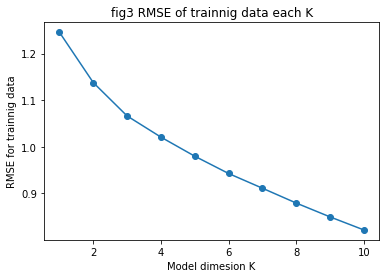

In [16]:
plt.title("fig3 RMSE of trainnig data each K")
plt.plot(Ks,RMSEs_,"o-")
plt.xlabel("Model dimesion K")
plt.ylabel("RMSE for trainnig data")
plt.show()

Seeing fig3, this RMSE for trainnnig data is smaller when the model dimension $k$ is larger, but RMSE for test data is not. It is supposed to be because too much degree of freedom cause overfitting.